# Measuring Objectivity using an LSTM Neural Network

_Daniela De la Parra_ <br>
_Rice University_ <br>
***

### Goal

Develop a machine learning algorithm that classifies sentences as objective or subjective based on the narrative structure of the sentence itself and its linguistic attributes. 


 <br> **_Supervised model:_**
- Learns patterns from labeled sentences (manually identified examples of objective and subjective sentences) and generalizes to new data that has not been seen before
- Predict the objectivity of sentences that were not used during the training process 
- After completion of the training phase, use the optimized model to predict the probability of each sentence being objective in the unlabeled sample

<img src="img/objective_subjective.png" style="width:900px" align="left"/>

### Manually Classify Sentences

I randomly select 3,000 sentences from the MD&A section of 10-K filings from my sample and manually classify each sentence into an “Objective” or a “Subjective” class, according to whether the information provided is based on facts or on opinions that may be subject to interpretation. 

My classification task results in 1,896 sentences being classified as “Objective” and 1,104 as “Subjective.”

| Label | Sentence |
| --- | :-|
| OBJ | "Our products are distributed in the United States and in over twenty (20) other countries."
| OBJ | "Chesapeake is the operator for the development of our oil and gas properties." |
| OBJ|"During the year ended December 31, 2004, we completed seven acquisitions."| 
| OBJ|"The purchase price was \\$1.8 million, \\$360,000 paid in cash and a \\$1.4 million promissory note that bears interest at 6.6\% per annum from the purchase date through the fourth anniversary date."| 
| SUBJ | "NS2 has completed a variety of toxicity studies in animals and appears generally safe and well-tolerated." |
| SUBJ | "Our losses, while greater than projected, were still modest considering the magnitude of the economic storm." |
| SUBJ | "We believe that our dedication to quality and durability and focus on our clients’ needs has created a high level of brand loyalty and has solidified substantial brand equity." |
| SUBJ | "The current economic and interest rate environments continue to challenge our organic growth plans." |

---
# Background

### Anatomy of a neural network

<img src="img/NN.png" style="width:600px" align="left"/>

### Simplest Neural Network: Perceptron

<font size="4">
$$
\begin{aligned}
    \hat{y} =& ~g(w_1 x_1 + w_2 x_2 + \dots + w_n x_n + b)  \\\\
    \hat{y} =& ~g({W}^{\top} \mathrm{x} + b)  \\\\
    & ~g(x) =
        \begin{cases}
            0 ~~~~\mathrm{if} ~~x < 0, \\
            1 ~~~~\mathrm{otherwise}
        \end{cases}
\end{aligned}
$$
</font>

<img src="img/perceptron.png" style="width:580px" align="left"/>

### Combining models: Increase complexity

<img src="img/multi_layer.png" style="width:600px" align="left"/>

### Multi-layer Perceptron

<img src="img/two_layer.png" style="width:700px" align="left"/>

---
# Back to Objectivity

<br>
<img src="img/objective_subjective.png" style="width:900px" align="left"/>
<br>

# Model

### Recurrent Neural Network

Given the widespread usage of recurrent neural networks (RNNs) in text analysis
applications and their capability of learning dependencies among sequences of words, I use this type of neural network for my classification task.

<img src="img/RNN.png" style="width:700px" align="left"/>

### Word Embeddings

In [1]:
# My data (example):

data = [
    ("Our oil production was 9% lower in 2008 than 2007.", 1),
    ("The impact of inflation on the Company's operations has not been significant to date.", 0),
    ("We believe that we can continue to operate efficiently in challenging economic and industry environments.", 0),
    ("The number of commercial sites in the U.S. is now approximately 400.", 1)
]

Words are discrete units that are not naturally associated to numeric values! 
In computational linguitics, we map words to vectors using word embeddings

<img src="img/embeddings.png" style="width:700px" align="left"/>

Analogies:

<font size="4">
$$
    \mathrm{woman} + \mathrm{queen} = \mathrm{man} + x \\
$$
</font>    
Solve for $x$:
<font size="4">
$$
\begin{aligned}
    x &= \mathrm{woman} + \mathrm{queen} - \mathrm{man} \\
    x &= \mathrm{king}
\end{aligned}
$$
</font>

The analogy feature also works for other types, such as adjectives, grammatical tenses, etc. 

<!-- 
There is a lot more that we can do with those vectors too:

<img src="img/embeddings2.jpg" style="width:700px"/> 
-->

### Vocabulary

In [2]:
import json

def load_vocab(path):
    with open(path, 'r') as fp:
        return json.load(fp)

vocab = load_vocab('train_model/word_to_index.json')

print(f"Vocabulary size: {len(vocab):,}")

Vocabulary size: 4,957


### Embedding Table

An embedding matrix $E$ contains our vocabulary $\mathcal{V}$, representing each word as a row vector of $d$ dimensions (i.e., $E \in \mathbb{R}^{|\mathcal{V}|~\times~d}$). <br>
(I use the vector embeddings _GloVe_ created by Pennington, Socher and Manning (2014).)

In [3]:
import torch.nn as nn

embedding = nn.Embedding(len(vocab), 50) # d = 50
embedding

Embedding(4957, 50)

Encoding words into indexes that point to an entry in the embedding table:

In [4]:
import numpy as np; np.set_printoptions(formatter={'float_kind':'{:>6.3f} '.format})

for word in ['i', 'do', 'research', 'in', 'accounting']:
    index = vocab[word]
    vector = embedding.weight[index, :5] # a few dimensions
    
    print(f"{word:<8}\t{index:>4}\t{vector.data.numpy()}")

i       	  43	[ 0.312  -0.339   0.541  -1.055  -0.973 ]
do      	  85	[-0.306   0.559   0.144   1.292   0.682 ]
research	 416	[ 0.789  -0.671  -0.719   0.806  -0.686 ]
in      	  11	[-1.819  -0.725  -1.024   0.310   1.563 ]
accounting	1816	[ 0.001  -0.360  -0.305   1.437   0.298 ]


### Split Corpus into Train (70%), Validation (15%), Test (15%)

I split my dataset into the train (70%), validation (15%), and test (15%) samples. The validation sample is used to provide an unbiased evaluation of the trained model and with it, fine-tune hyperparameters.

In [5]:
from utils import ObjSubDataset, embedded_data
from nltk import word_tokenize
from sklearn.model_selection import train_test_split

def split_corpus(data):
    X = []
    Y = []

    for row in data:
        X.append(data[0])
        Y.append(data[1])

    X_trn, X_tmp, Y_trn, Y_tmp = train_test_split(X, Y, test_size=0.3, random_state=1)
    X_dev, X_tst, Y_dev, Y_tst = train_test_split(X_tmp, Y_tmp, test_size=0.5, random_state=1)

    return {
        'train_X': X_trn, 'train_Y': Y_trn,
        'dev_X': X_dev, 'dev_Y': Y_dev,
        'test_X': X_tst, 'test_Y': Y_tst,
        }

sent_dataset = split_corpus(embedded_data)

datasets = {
    'train': ObjSubDataset(sentences=sent_dataset['train_X'], labels=sent_dataset['train_Y']),
    'dev':   ObjSubDataset(sentences=sent_dataset['dev_X'],   labels=sent_dataset['dev_Y']),
    'test':  ObjSubDataset(sentences=sent_dataset['test_X'],  labels=sent_dataset['test_Y'])
}

### Implementing the model: Bidirectional Long Short-Term Memory (LSTM)

I use a particular type of RNN called Long Short-Term Memory (LSTM) network, which specializes in ‘remembering’ relevant context from long-term sequences and at the same time ‘forgetting’ irrelevant short-term information (Hochreiter and Schmidhuber 1997).

In [6]:
import torch

class LSTMLayer(nn.Module):
    def __init__(self, input_dim, lstm_dim):
        super(LSTMLayer, self).__init__()

        self.lstm_dim = lstm_dim
        self.lstm = nn.LSTM(input_dim, lstm_dim // 2, bidirectional=True, batch_first=True)

    def forward(self, vectors, mask):
        lstm_outs, _ = self.lstm(vectors)
        return lstm_outs

In [7]:
lstm = LSTMLayer(input_dim=50, lstm_dim=128)
lstm

LSTMLayer(
  (lstm): LSTM(50, 64, batch_first=True, bidirectional=True)
)

<img src="img/bidirectional_lstm.png" style="width:600px" align="left"/>

### Attention Mechanism

The attention mechanism was introduced in neural machine translation (NMT) by Bahdanau et al. (2015). 
The idea is to automatically focus on specific parts of the text to emphasize the context for the task at hand.

<br>
<font size="4">
$$
\begin{align} 
	u_i =&~ v^\top ~\mathrm{tanh}(W_h h_i + b_i) \label{eq:att-raw-scores} \\\\
	\alpha_i =&~ \frac{\mathrm{exp}(u_i)}{\sum^{N}_{j=1}\mathrm{exp}(u_j)}, ~~~\text{s.t.}~\sum_{i=1} \alpha_i = 1 \label{eq:att-alpha} \\\\
	z =& \sum_{i=1}{\alpha_i h_i}
\end{align}
$$
<font/>

In [8]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()

        self.W = nn.Linear(input_dim, input_dim)
        self.v = nn.Linear(input_dim, 1)

    def forward(self, inputs, mask):
        # Raw scores
        u = self.v(torch.tanh(self.W(inputs)))

        # Masked softmax
        u = u.exp()                              
        u = mask.unsqueeze(2).float() * u       
        sums = torch.sum(u, dim=1, keepdim=True)  
        a = u / sums                            

        # Weighted sum of the input vectors
        z = torch.sum(inputs * a, dim=1)

        return z, a.view(inputs.size(0), inputs.size(1))

In [9]:
attention = AttentionLayer(input_dim=128) 
attention

AttentionLayer(
  (W): Linear(in_features=128, out_features=128, bias=True)
  (v): Linear(in_features=128, out_features=1, bias=True)
)

### Putting the model together

In [10]:
import torch.nn.functional as F

class ObjSubModel(nn.Module):
    def __init__(self, n_classes):
        super(ObjSubModel, self).__init__()

        self.n_classes = n_classes

        self.embeddings = embedding
        self.lstm = lstm
        self.attn = attention
        self.classifier = nn.Linear(lstm.lstm_dim, n_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, encodings, mask, y=None):
        # Step 1: embed the encodings
        embedded = self.embeddings(encodings)
        
        # Step 2: process the embeddings with LSTM
        lstm_outs = self.lstm(embedded, mask)
        lstm_outs = self.dropout(lstm_outs)
        
        # Step 3: reduce the sequence into a single vector using attention 
        attn_out, attn_weights = self.attn(lstm_outs, mask)
        attn_out = self.dropout(attn_out)
        
        # Step 4: map the sentence vector to the binary classification space
        scores = self.classifier(attn_out)
        probs = torch.softmax(scores, dim=1)
        
        loss = 0
        if y is not None:
            loss = F.cross_entropy(scores, y, reduction='mean')
            loss += l2reg(self.parameters()) * 1e-2 # L2 regularization with lambda = 1e-2

        return probs, loss, attn_weights

In [11]:
model = ObjSubModel(n_classes=2)
model

ObjSubModel(
  (embeddings): Embedding(4957, 50)
  (lstm): LSTMLayer(
    (lstm): LSTM(50, 64, batch_first=True, bidirectional=True)
  )
  (attn): AttentionLayer(
    (W): Linear(in_features=128, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Training Results

<img src="img/train_dev_metrics.png" style="width:700px" align="left"/>

The ROC metric shows that the model has a good fit, with an outstanding (excellent)
discrimination ability in the train (validation) sample (Kim and Skinner 2012). An evaluation of the trained model on the test sample achieved an accuracy of 0.87 on the classification of Objective sentences

<img src="img/test_metrics.png" style="width:700px" align="left"/>

### Predicting

In [12]:
import utils
from nltk import word_tokenize

utils.load_model('train_model/lstm_attn_model.pt', model)

In [13]:
sentences = [
    "World operates both passenger and cargo missions for the AMC international program while North American  " \
        "operates only passenger missions.",
    
    "While variation in the size of program award makes it difficult to directly correlate this data to our " \
        "sales trends, we believe it does provide useful information regarding our customer loyalty and new " \
        "business growth.",
    
    "During 2006, we fully utilized our net operating loss carryforwards for federal income tax purposes.",
    
    "We believe our principal sources of liquidity from available funds on hand, cash generated from operations, " \
        "and the availability of borrowing under our credit facilities will be sufficient to meet our working " \
        "capital and other operating needs for at least the next 12 months.",
]

sentences_tok = [word_tokenize(s) for s in sentences]
labels, probs, attns = utils.predict(sentences_tok, vocab, model)
labels

['objective', 'subjective', 'objective', 'subjective']

In [14]:
print("\t\tProbabilities\n")
print("Sentence # \tSubjective \tObjective")
for i, p in enumerate(probs):
    print(f"\t{i+1}\t{round(p[0], 5)}\t\t{round(p[1], 5)}")

		Probabilities

Sentence # 	Subjective 	Objective
	1	0.00355		0.99645
	2	0.99314		0.00686
	3	0.44686		0.55314
	4	0.99965		0.00035


### Visualization

Sentence: 
World operates both passenger and cargo missions for the AMC international program while North American  operates only passenger missions.


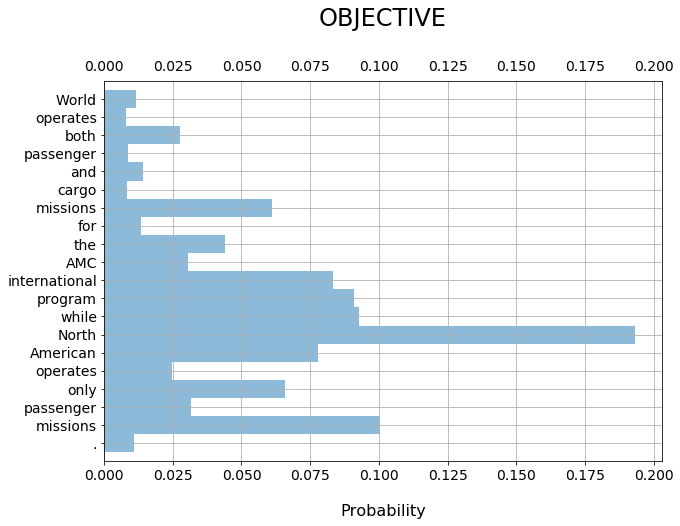

Sentence: 
While variation in the size of program award makes it difficult to directly correlate this data to our sales trends, we believe it does provide useful information regarding our customer loyalty and new business growth.


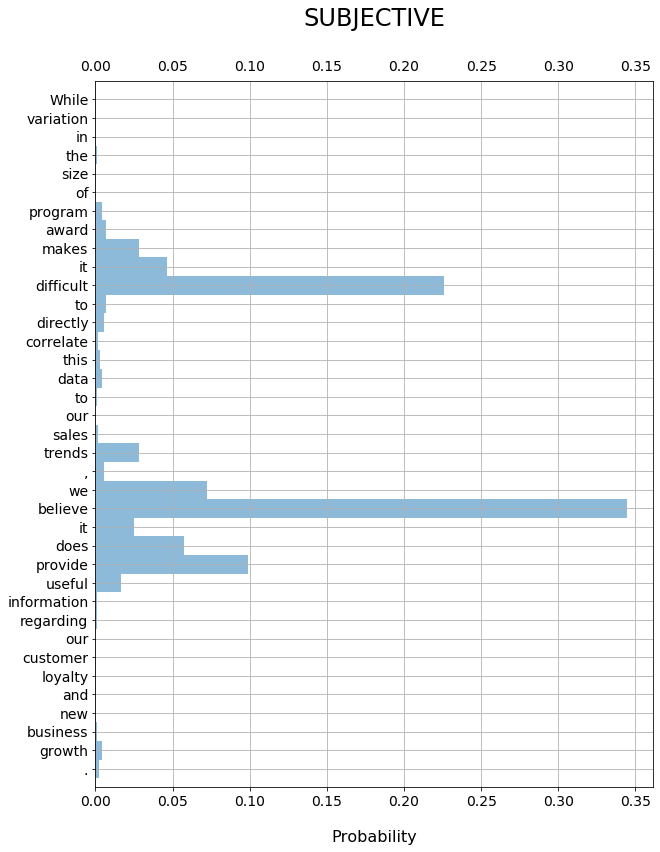

Sentence: 
During 2006, we fully utilized our net operating loss carryforwards for federal income tax purposes.


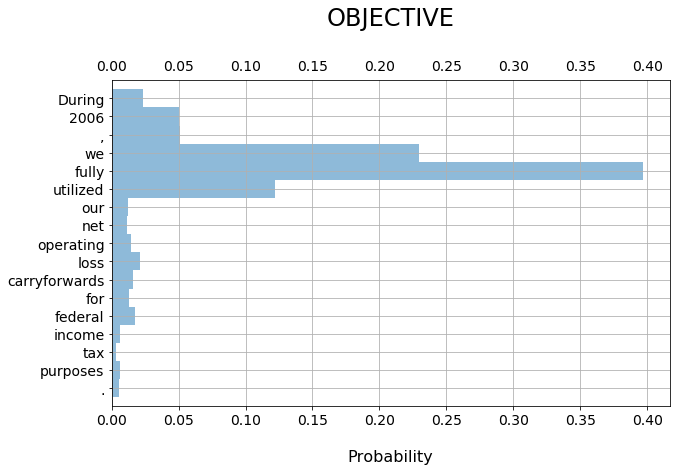

Sentence: 
We believe our principal sources of liquidity from available funds on hand, cash generated from operations, and the availability of borrowing under our credit facilities will be sufficient to meet our working capital and other operating needs for at least the next 12 months.


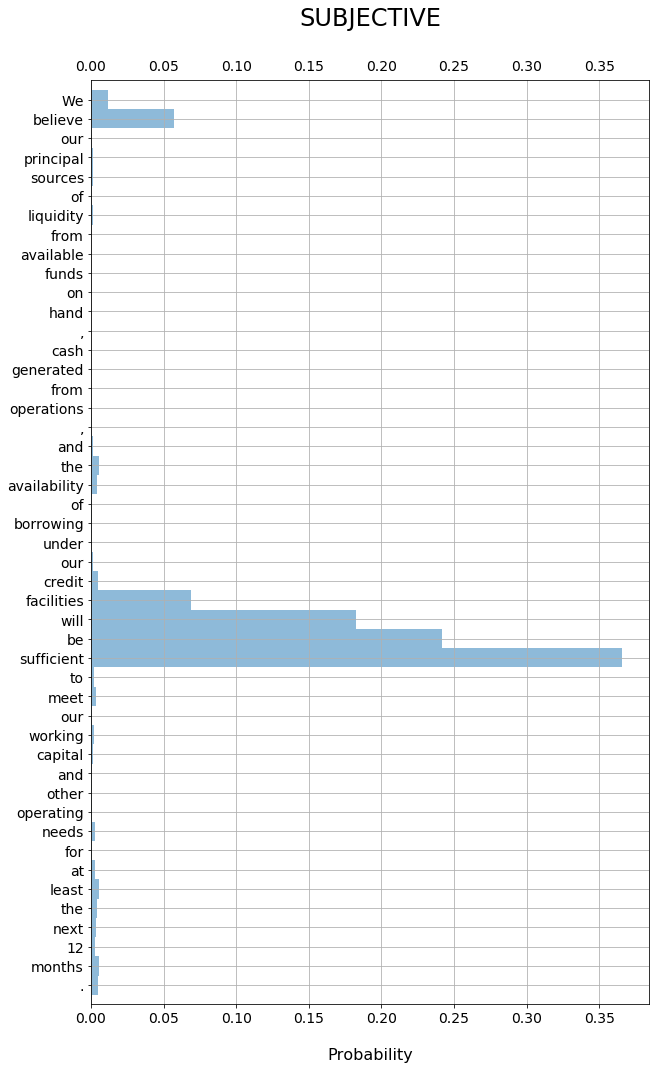

In [15]:
for sent, words, label, attn in [d for d in zip(sentences, sentences_tok, labels, attns)]:
    print(f"Sentence: \n{sent}")
    utils.plot_attention_bars(words, attn, label, horbars=True, word_axis=2.8, value_axis=10)

### Conclusion

Neural networks are a remarkably powerful and efficient approach to analyzing textual data in a complex, high-dimensional space!

As opposed to a bag-of-words approach—which consists of searching for matches of specific words from an arbitrarily-constructed wordlist—, the complexity of the layers composing a neural network allows it to take into account the order of words, the context of each word, the grammatical structure of sentences, and the meaning of ideas derived from ordered words.

### Sources

1. Fang, L., Luo, Y., Feng, K., Zhao, K., & Hu, A. (2019, May). Knowledge-enhanced ensemble learning for word embeddings. In The World Wide Web Conference (pp. 427-437). DOI:https://doi.org/10.1145/3308558.3313425


2. Chollet F. 2017. Deep learning with Python. Manning Publications Company.


3. http://colah.github.io/posts/2015-08-Understanding-LSTMs/


4. Hochreiter S, Schmidhuber J. 1997. Long Short-Term Memory. Neural Computation 9: 1735–1780. URL https://doi.org/10.1162/neco.1997.9.8.1735


5. Pennington J, Socher R, Manning CD. 2014. GloVe: Global Vectors for Word Representation. Empirical Methods in Natural Language Processing: 1532–1543. URL http://www.aclweb.org/anthology/D14-1162


6. Mikolov T, Yih Wt, Zweig G. 2013. Linguistic Regularities in Continuous Space Word Representations. Proceedings of NAACL-HLT: 746–751.


7. Bahdanau D, Cho K, Bengio Y. 2014. Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.


8. Zhang Y, Zhong V, Chen D, Angeli G, Manning CD. 2017. Position-aware Attention and Supervised Data Improve Slot Filling. EMNLP 2017 - Conference on Empirical Methods in Natural Language Processing, Proceedings : 35–45.


9. http://colah.github.io/posts/2015-09-NN-Types-FP/


10. Goodfellow I, Bengio Y, Courville A. 2016. Deep Learning. MIT Press. URL http://www.deeplearningbook.org


11. Alpaydin E. 2014. Introduction to Machine Learning. MIT Press. ISBN 978-0–262-028189.


12. Kim I, Skinner DJ. 2012. Measuring securities litigation risk. Journal of Accounting and Economics 53: 290–310. ISSN 01654101. URL http://dx.doi.org/10.1016/j.jacceco.2011.09.005

In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))